# 5. Non-Cartesian radial under-sampling

In this notebook, you can play with the design parameters to regenerate
different radial in-out patterns (so, we draw radial spokes over a rotating
angle of $\pi$). You can play with the number of shots by changing the
under-sampling factor.

- Author: Philippe Ciuciu (philippe.ciuciu@cea.fr)
- Date: 06/24/2022
- Update: 01/29/2024 (dependence on MRI-NUFFT for density compensation)
- Update: 02/04/2025 (remove dependence on pysap)
- Target: [IEEE EMBS-SPS Summer School](http://conferences.imt-atlantique.fr/ieeess/index.php?pid=1) on **Novel acquisition and image reconstruction strategies in accelerated Magnetic Resonance Imaging**

(256, 256)


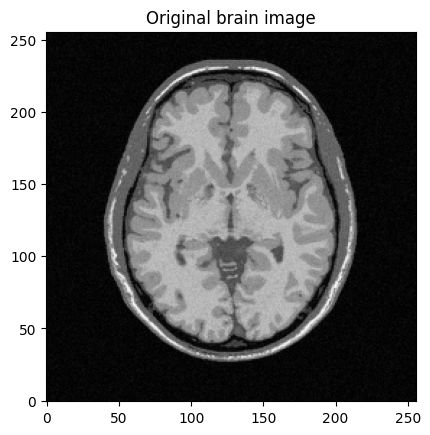

In [1]:
#DISPLAY BRAIN PHANTOM
%matplotlib inline

import numpy as np
import os.path as op
import os
import math ; import cmath
import matplotlib.pyplot as plt
import sys
import mrinufft
from mrinufft.trajectories import display_2D_trajectory, initialize_2D_radial


import brainweb_dl as bwdl
from mrinufft import get_density
from mrinufft.density import voronoi

from skimage import data, img_as_float, io, filters
from modopt.math.metrics import ssim

plt.rcParams["image.origin"]="lower"
plt.rcParams["image.cmap"]='Greys_r'

#mri_img = get_sample_data('2d-mri')
#img_size = mri_img.shape[0]

#plt.figure()
#plt.title("T2* axial slice, size = {}".format(img_size))
#plt.imshow(mri_img, cmap=plt.cm.gray)
#plt.show()

mri_img = bwdl.get_mri(4, "T1")[70, ...].astype(np.float32)
#mri_img = bwdl.get_mri(4, "T2")[120, ...].astype(np.float32)
print(mri_img.shape)
img_size = mri_img.shape[0]
plt.figure()
plt.imshow(abs(mri_img))
#plt.imshow(abs(mri_2D),origin="lower")
#plt.imshow(abs(mri_2D),origin="upper")
plt.title("Original brain image")
plt.show()


number of shots: 64
number of samples per shot: 256


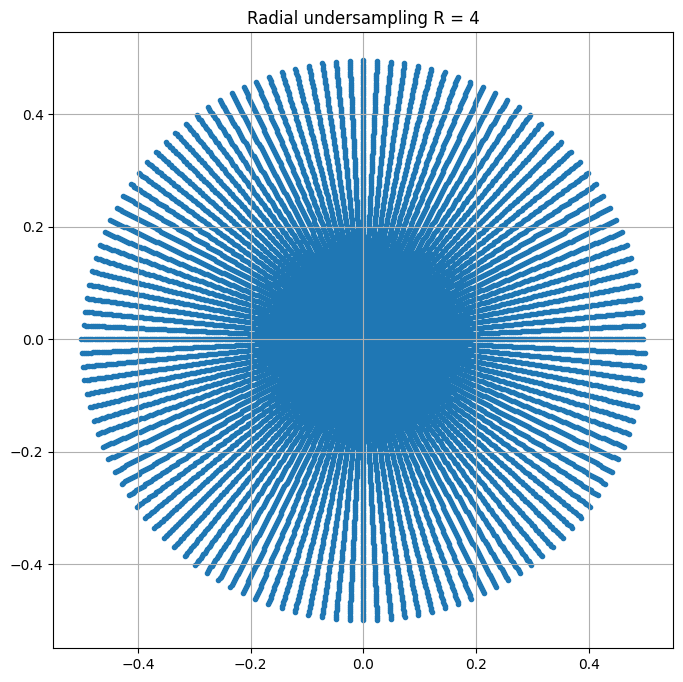

In [17]:
# set up the first shot
rfactor = 4
nb_shots = math.ceil(img_size/rfactor)
print("number of shots: {}".format(nb_shots))

# vectorize the nb of shots
vec_shots = np.arange(0,nb_shots)

# define the regularly spaced samples on a single shot
nsamples = (np.arange(0,img_size) - img_size//2)/(img_size)
print("number of samples per shot: {}".format(np.size(nsamples)))

shot_c = np.array(nsamples, dtype = np.complex_)
shots = np.array([], dtype = np.complex_)
# acculumate shots after rotating the initial one by the right angular increment
for k in vec_shots:
    shots = np.append(shots, shot_c * np.exp(2 * np.pi * 1j * k/(2*nb_shots)))

kspace_loc = np.zeros((len(shots),2))

#assign real and imaginary parts of complex-valued k-space trajectories to k-space locations
kspace_loc[:,0] = shots.real
kspace_loc[:,1] = shots.imag
#Plot full initialization
kspace = plt.figure(figsize = (8,8))
#plot shots
plt.scatter(kspace_loc[:,0],kspace_loc[:,1], marker = '.')
plt.title("Radial undersampling R = %d" %rfactor)

axes = plt.gca()
plt.grid()

In [21]:
#kspace_loc = mrinufft.initialize_2D_radial(Nc=nb_shots, Ns=nsamples)

## The real deal starts here ##
# Choose your NUFFT backend (installed independly from the package)
NufftOperator = mrinufft.get_operator("finufft")

# For better image quality we use a density compensation
density = "voronoi"
#density = "cell_count"
#density = None
# And create the associated operator.
if density == None:
    nufft = NufftOperator(
        kspace_loc.reshape(-1, 2), shape=mri_img.shape, density=None, n_coils=1
    )
elif density == "voronoi":
    voronoi_weights = get_density("voronoi", kspace_loc.reshape(-1, 2))
    nufft = NufftOperator(
        kspace_loc.reshape(-1, 2), shape=mri_img.shape, density=voronoi_weights, n_coils=1
    )
else:
    cell_count_weights = get_density("cell_count", kspace_loc.reshape(-1, 2), shape=mri_img.shape, osf=2.0)
    nufft = NufftOperator(
        kspace_loc.reshape(-1, 2), shape=mri_img.shape, density=cell_count_weights, n_coils=1, upsampfac=2.0
    )

kspace_obs = nufft.op(mri_img)  # Image -> Kspace
image2 = nufft.adj_op(kspace_obs)  # Kspace -> Image

/volatile/home/pc174679/codes/venv/lib/python3.10/site-packages/mrinufft/_utils.py:94: UserWarning: Samples will be rescaled to [-pi, pi), assuming they were in [-0.5, 0.5)
  warnings.warn(
/volatile/home/pc174679/codes/venv/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `data` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")


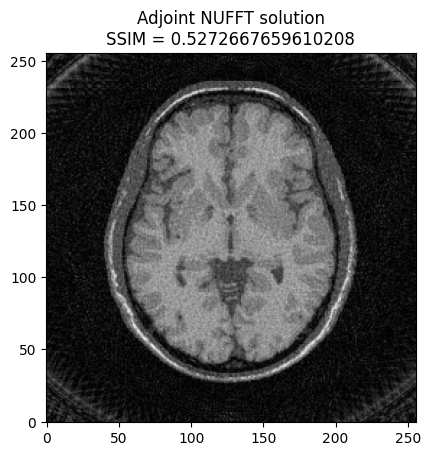

In [19]:
grid_space = np.linspace(-0.5, 0.5, num=mri_img.shape[0])
grid2D = np.meshgrid(grid_space, grid_space)
#grid_soln = gridded_inverse_fourier_transform_nd(kspace_loc, kspace_obs,
#                                                 tuple(grid2D), 'linear')
plt.imshow(np.abs(image2), cmap='gray')
# Calculate SSIM
base_ssim = ssim(image2, mri_img)
plt.title('Adjoint NUFFT solution\nSSIM = ' + str(base_ssim))
plt.show()

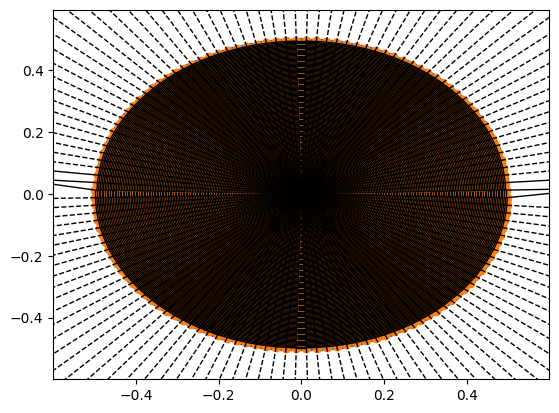

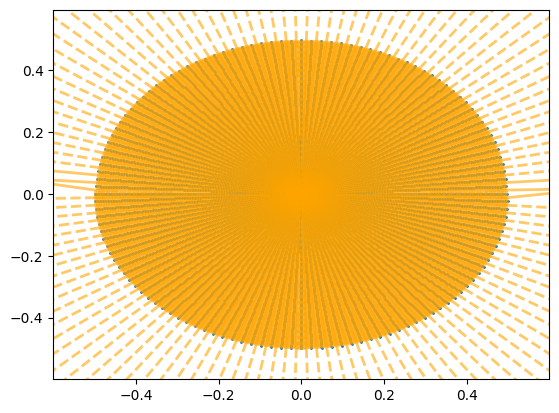

In [20]:
from scipy.spatial import Voronoi, voronoi_plot_2d
import numpy as np

vor = Voronoi(kspace_loc.reshape(-1, 2))

fig = voronoi_plot_2d(vor)

fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='orange',
                      line_width=2, line_alpha=0.6, point_size=2)
plt.show()

(434, 362)


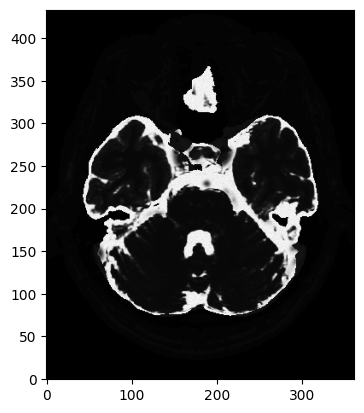

In [27]:
# T2 weighted image
mri_2D = bwdl.get_mri(4, "T2")[80, ...].astype(np.float32)
print(mri_2D.shape)
plt.figure()
plt.imshow(abs(mri_2D))
plt.show()

In [ ]:
from mrinufft import get_density, get_operator, check_backend

traj = initialize_2D_radial(256, 256).astype(np.float32)

nufft = get_operator("finufft")(traj, mri_2D.shape, density=False)
kspace = nufft.op(mri_2D)
adjoint = nufft.adj_op(kspace)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(abs(mri_2D))
axs[0].set_title("Ground Truth")
display_2D_trajectory(traj, subfigure=axs[1])
axs[1].set_title("Radial sampling pattern")
axs[2].imshow(abs(adjoint))
axs[1].set_title("No density compensation")

voronoi_weights = get_density("voronoi", traj)
nufft_voronoi = get_operator("finufft")(
    traj, shape=mri_2D.shape, density=voronoi_weights
)
adjoint_voronoi = nufft_voronoi.adj_op(kspace)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(abs(mri_2D))
axs[0].set_title("Ground Truth")
display_2D_trajectory(traj, subfigure=axs[1])
axs[1].set_title("Radial sampling pattern")
axs[2].imshow(abs(adjoint_voronoi))
axs[2].set_title("Voronoi diagram based density compensation")

flat_traj = traj.reshape(-1, 2)
weights = np.sqrt(np.sum(flat_traj**2, axis=1))
nufft = get_operator("finufft")(traj, shape=mri_2D.shape, density=weights)
adjoint_manual = nufft.adj_op(kspace)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(abs(mri_2D))
axs[0].set_title("Ground Truth")
axs[1].imshow(abs(adjoint))
axs[1].set_title("no density compensation")
axs[2].imshow(abs(adjoint_manual))
axs[2].set_title("manual density compensation")